This script plots all the flood locations by day.

In [1]:
from db_scripts.get_server_data import data_dir, fig_dir
from db_scripts.focus_intersection import subset_locations
import pandas as pd
import matplotlib.pyplot as plt
import math
from mpl_toolkits.basemap import Basemap
import numpy as np
import time
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

In [2]:
flood_df = pd.read_csv('{}norfolk_flooded_roads_data/STORM_data_flooded_streets_2010-2016_no_duplicates_clean_lat_lon.csv'.format(data_dir))
# flood_df = flood_df[flood_df['location'].isin(subset_locations)]

In [3]:
flood_df['_date'] = pd.to_datetime(flood_df['_date'])
all_dates = pd.to_datetime(flood_df['_date'].unique())
num_plots = len(all_dates)
num_plots

82

In [4]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))

In [5]:
def get_num_rows(num_plots, ncols):
    return int(math.ceil(len(num_plots)/float(ncols)))

/home/jeff/miniconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/jeff/miniconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


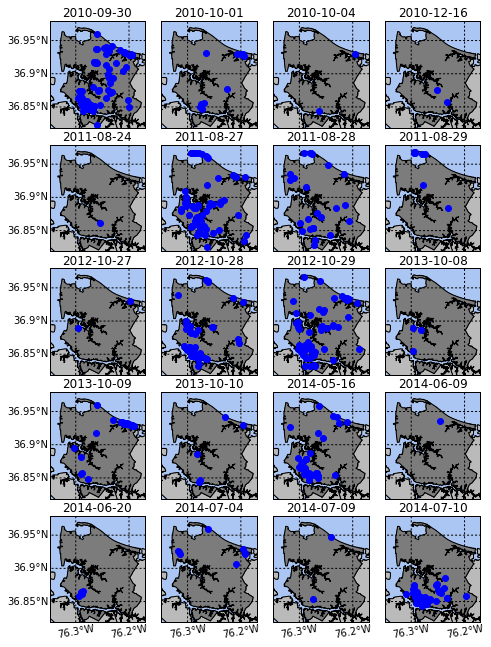

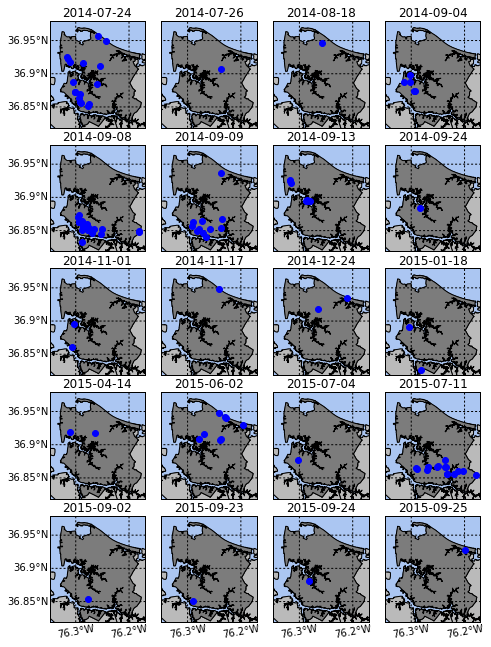

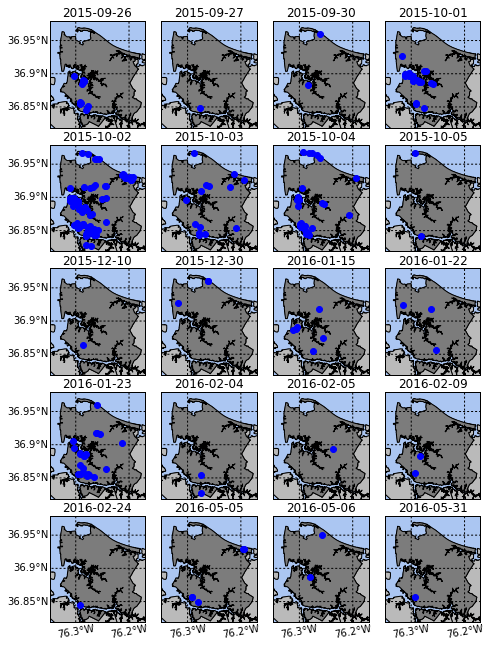

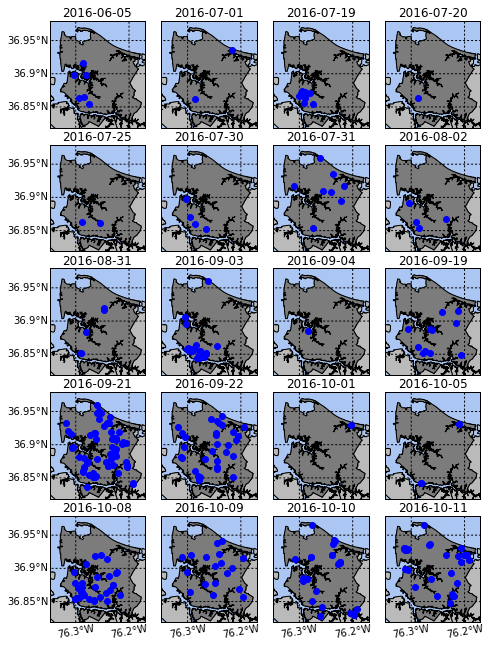

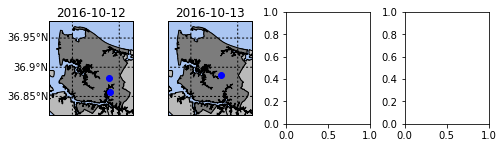

In [6]:
ncols = 4
for date_group in chunker(all_dates, 20):
    nrows = get_num_rows(date_group, ncols)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6.75, 9.*nrows/5.))
    ax_list = axs.ravel()
    for i in range(len(date_group)):
        plot_df = flood_df[flood_df['_date'] == date_group[i]]
        ax = ax_list[i]
        lats = flood_df['lat']
        lons = flood_df['lon']
        m = Basemap(resolution='c', projection='tmerc', lat_0 = lats.mean(), lon_0 = lons.mean(), ax=ax,
                    llcrnrlon=lons.min()*1.0004,llcrnrlat=lats.min()*0.9999,
                    urcrnrlon=lons.max()*0.9999,urcrnrlat=lats.max()*1.0003)
        
        m.drawmapboundary(fill_color='#abc6f2')
        m.readshapefile('{}GIS Data/nor_and_surr_counties_clip'.format(data_dir), 'surr')    
        m.readshapefile('{}GIS Data/norfolk_boundary_wgs'.format(data_dir), 'norfolk')
    
        # fill the shapefile pygns
        surr_patches   = []
        for shape in m.surr:
                surr_patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(surr_patches, facecolor= '#bababa', edgecolor='k', linewidths=1., 
                                          zorder=2))

        nor_patches   = []
        for shape in m.norfolk:
                nor_patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(nor_patches, facecolor= '#7c7c7c', edgecolor='k', linewidths=1., 
                                          zorder=2))

    
        latlabels = [1, 0, 0, 1] if i in [0, 4, 8, 12, 16] else [0, 0, 0, 0]
        lonlabels = [1, 0, 0, 1] if i > 15 else [0, 0, 0, 0]
        m.drawparallels(np.arange(34,38,0.05), labels=latlabels)
        meridians = m.drawmeridians(np.arange(-77, -75, 0.1), labels=lonlabels)
        for mer in meridians:
            try:
                meridians[mer][1][0].set_rotation(10)
            except:
                pass

        x,y = m(plot_df['lon'].tolist(), plot_df['lat'].tolist())
        m.plot(x, y, 'bo', markersize=6)
        ax.set_title(date_group[i].strftime('%Y-%m-%d'), y=0.98)
    fig.tight_layout(pad=0)
    fig.subplots_adjust(left=0.08, bottom=0.05)
    plt.savefig('{}plot_by_date_{}'.format(fig_dir, date_group[i].strftime('%Y-%m-%d')), dpi=300)
    plt.show()

---
I noticed that a lot of the days are grouped together. For example 2015-09-23 to 2015-10-05 there are 11/13 days that are flooded. There are other similar instances where more than one day in a row are flooded. So I got to thinking to myself, maybe the "date" field isn't the best to look at but maybe we should be looking at the "event" column instead.

In [7]:
len(flood_df['event'].unique())

47

In [8]:
group=flood_df.groupby('event')['_date'].nunique()
group.sort_values(ascending=False)

event
Hurricane Matthew (10/5/2016)      7
Joaquin (9/29/2015)                6
Noreaster (9/24/2015)              4
Irene (8/27/2011)                  4
unnamed  (9/20/2016)               4
Nicole (9/30/2010)                 3
unnamed  (2/25/2016)               3
unnamed  (2/1/2016)                3
Heavy Rain (10/9/2013)             3
Sandy (10/28/2012)                 3
Jan Winter Weather (1/20/2016)     2
unnamed  (11/23/2014)              2
unnamed  (7/2/2015)                2
Rainy Monday (9/8/2014)            2
unnamed  (7/24/2014)               2
unnamed  (7/30/2016)               2
HERMINE (9/2/2016)                 2
unnamed  (3/2/2015)                2
Heavy Rainfall (12/30/2015)        1
unnamed  (9/29/2014)               1
Heavy Rain (5/16/2014)             1
HEAVY RAIN (9/24/2014)             1
HEAVY RAIN (9/19/2016)             1
Bernie (Training) (7/25/2016)      1
Arthur (7/3/2014)                  1
AUG 18 2014 (8/18/2014)            1
7/10 Thunderstorms (7/10/2014)  

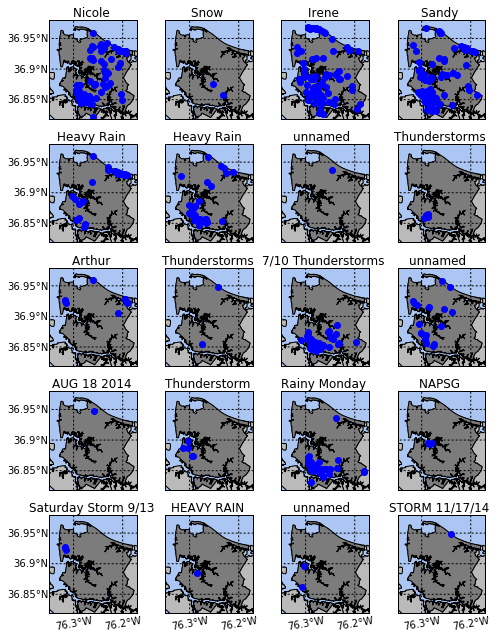

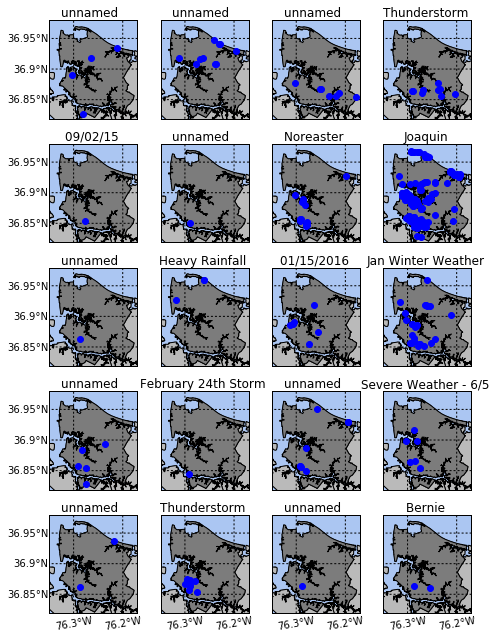

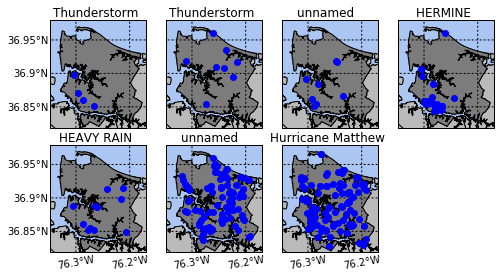

In [9]:
ncols = 4
for date_group in chunker(flood_df['event'].unique(), 20):
    nrows = get_num_rows(date_group, ncols)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6.75, 9.*nrows/5.))
    ax_list = axs.ravel()
    for i in range(len(date_group)):
        plot_df = flood_df[flood_df['event'] == date_group[i]]
        ax = ax_list[i]
        lats = flood_df['lat']
        lons = flood_df['lon']
        m = Basemap(resolution='c', projection='tmerc', lat_0 = lats.mean(), lon_0 = lons.mean(), ax=ax,
                    llcrnrlon=lons.min()*1.0004,llcrnrlat=lats.min()*0.9999,
                    urcrnrlon=lons.max()*0.9999,urcrnrlat=lats.max()*1.0003)
        
        m.drawmapboundary(fill_color='#abc6f2')
        m.readshapefile('{}GIS Data/nor_and_surr_counties_clip'.format(data_dir), 'surr')    
        m.readshapefile('{}GIS Data/norfolk_boundary_wgs'.format(data_dir), 'norfolk')
    
        # fill the shapefile pygns
        surr_patches   = []
        for shape in m.surr:
                surr_patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(surr_patches, facecolor= '#bababa', edgecolor='k', linewidths=1., 
                                          zorder=2))

        nor_patches   = []
        for shape in m.norfolk:
                nor_patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(nor_patches, facecolor= '#7c7c7c', edgecolor='k', linewidths=1., 
                                          zorder=2))

    
        latlabels = [1, 0, 0, 1] if i in [0, 4, 8, 12, 16] else [0, 0, 0, 0]
        lonlabels = [1, 0, 0, 1] if i > len(ax_list)-5 else [0, 0, 0, 0]
        m.drawparallels(np.arange(34,38,0.05), labels=latlabels)
        meridians = m.drawmeridians(np.arange(-77, -75, 0.1), labels=lonlabels)
        for mer in meridians:
            try:
                meridians[mer][1][0].set_rotation(10)
            except:
                pass

        x,y = m(plot_df['lon'].tolist(), plot_df['lat'].tolist())
        m.plot(x, y, 'bo', markersize=6)
        ax.set_title(date_group[i].split('(')[0], y=0.98)
    for ax in ax_list:
        if not ax.has_data():
            fig.delaxes(ax)
    fig.tight_layout(pad=0)
    fig.subplots_adjust(left=0.08, bottom=0.05)
    plt.savefig('{}plot_by_date_{}.png'.format(fig_dir, date_group[i].split('(')[0].replace("/","_")), dpi=300)
    plt.show()